Final btc_all row count: 39
Date range: 2024-12-17 to 2025-02-14
                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     1.689
Date:                Fri, 21 Mar 2025   Prob (F-statistic):              0.175
Time:                        16:43:25   Log-Likelihood:                 92.919
No. Observations:                  39   AIC:                            -175.8
Df Residuals:                      34   BIC:                            -167.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

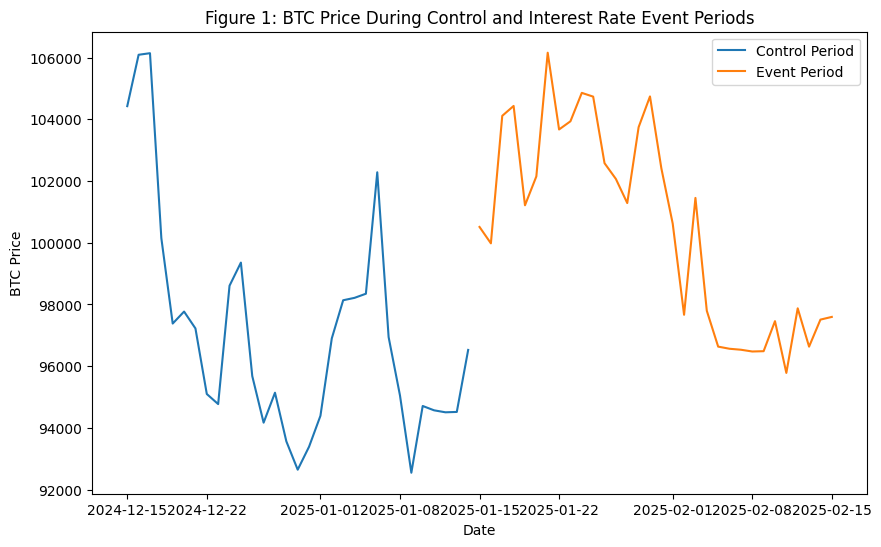

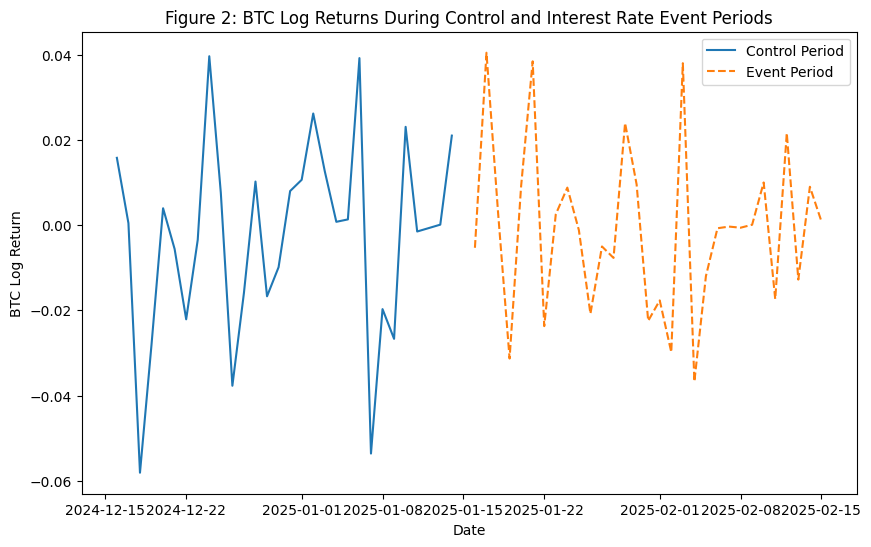

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os

# Define base data directory
base_data_dir = "../data"

# Load Bitcoin Data
btc_control = pd.read_csv(os.path.join(base_data_dir, 'btc_interest_rate_control_period_clean.csv'), parse_dates=['date'])
btc_event = pd.read_csv(os.path.join(base_data_dir, 'btc_interest_rate_event_period_clean.csv'), parse_dates=['date'])

btc_control['log_return'] = np.log(btc_control['close'] / btc_control['close'].shift(1))
btc_event['log_return'] = np.log(btc_event['close'] / btc_event['close'].shift(1))

btc_all = pd.concat([btc_control, btc_event])
btc_all['event_period'] = btc_all['date'].apply(lambda d: 1 if d in btc_event['date'].values else 0)

# Load market control data
sp500_control = pd.read_csv(os.path.join(base_data_dir, 'sp500_interest_rate_control_period_clean.csv'), parse_dates=['date'])
sp500_event = pd.read_csv(os.path.join(base_data_dir, 'sp500_interest_rate_event_period_clean.csv'), parse_dates=['date'])
sp500_all = pd.concat([sp500_control, sp500_event])
sp500_all.rename(columns={"close": "sp500_close"}, inplace=True)
sp500_all['sp500_return'] = sp500_all['sp500_close'].pct_change()

vix_control = pd.read_csv(os.path.join(base_data_dir, 'vix_interest_rate_control_period_clean.csv'), parse_dates=['date'])
vix_event = pd.read_csv(os.path.join(base_data_dir, 'vix_interest_rate_event_period_clean.csv'), parse_dates=['date'])
vix_all = pd.concat([vix_control, vix_event])
vix_all.rename(columns={"close": "vix_close"}, inplace=True)
vix_all['vix_change'] = vix_all['vix_close'].pct_change()

treasury_control = pd.read_csv(os.path.join(base_data_dir, 'treasury_yield_interest_rate_control_period_clean.csv'), parse_dates=['date'])
treasury_event = pd.read_csv(os.path.join(base_data_dir, 'treasury_yield_interest_rate_event_period_clean.csv'), parse_dates=['date'])
treasury_all = pd.concat([treasury_control, treasury_event])
treasury_all['yield_change'] = treasury_all['treasury_yield'].diff()

# Convert dates
btc_all['date'] = btc_all['date'].dt.date
sp500_all['date'] = sp500_all['date'].dt.date
vix_all['date'] = vix_all['date'].dt.date
treasury_all['date'] = treasury_all['date'].dt.date

# Merge all control variables into Bitcoin data
btc_all = btc_all.merge(sp500_all[['date', 'sp500_return']], on='date', how='left')
btc_all = btc_all.merge(vix_all[['date', 'vix_change']], on='date', how='left')
btc_all = btc_all.merge(treasury_all[['date', 'yield_change']], on='date', how='left')

# Clean data
btc_all.dropna(subset=['log_return', 'sp500_return', 'vix_change', 'yield_change'], inplace=True)

# Descriptive statistics
descriptive_stats_control = btc_control[['log_return']].describe().T
descriptive_stats_event = btc_event[['log_return']].describe().T
descriptive_stats_combined = btc_all[['log_return', 'sp500_return', 'vix_change', 'yield_change']].describe().T

descriptive_stats_control.to_csv("../tables/ratecut_descriptive_stats_control.csv")
descriptive_stats_event.to_csv("../tables/ratecut_descriptive_stats_event.csv")
descriptive_stats_combined.to_csv("../tables/ratecut_descriptive_stats_combined.csv")

# Difference-in-Differences regression
if btc_all.empty:
    raise ValueError("btc_all is empty after merging — check that all datasets overlap in date ranges.")
X = sm.add_constant(btc_all[['event_period', 'sp500_return', 'vix_change', 'yield_change']])
y = btc_all['log_return']
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

# Plot price comparison
plt.figure(figsize=(10, 6))
plt.plot(btc_control['date'], btc_control['close'], label='Control Period')
plt.plot(btc_event['date'], btc_event['close'], label='Event Period')
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.title("Figure 1: BTC Price During Control and Interest Rate Event Periods")
plt.legend()
plt.show()

# Plot log returns
plt.figure(figsize=(10, 6))
plt.plot(btc_control['date'], btc_control['log_return'], label='Control Period')
plt.plot(btc_event['date'], btc_event['log_return'], label='Event Period', linestyle='--')
plt.xlabel("Date")
plt.ylabel("BTC Log Return")
plt.title("Figure 2: BTC Log Returns During Control and Interest Rate Event Periods")
plt.legend()
plt.show()
